In [ ]:
!pip install adversarial-robustness-toolbox


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.9 MB/s eta 0:00:00


In [ ]:
import time
import numpy as np
import torch.nn as nn
from datetime import datetime

from PIL import Image
from torchvision import transforms
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt

from art.estimators.classification import PyTorchClassifier
from skimage.metrics import structural_similarity as ssim

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import FastGradientMethod

In [ ]:
def softmax_activation(inputs):
    inputs = inputs.tolist()
    exp_values = np.exp(inputs - np.max(inputs))

    # Normalize
    probabilities = exp_values / np.sum(exp_values)
    return probabilities

In [ ]:
def compare_images(imageA, imageB):
    return 1 - ssim(imageA, imageB, multichannel=True)

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [ ]:
model_resnet18 = models.resnet18(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()

# Create the ART classifier

classifier = PyTorchClassifier(
    model=model_resnet18,
    loss=criterion,
    input_shape=(3, 224, 224),
    nb_classes=1000,
    device_type='gpu'
)

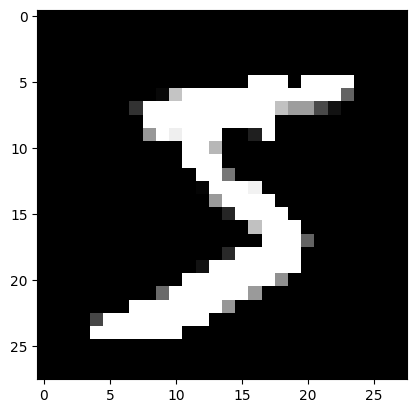

Shape of input_batch: (3, 3, 28, 28)
Length of input_batch: 3


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Time for attack (in seconds): 5.455967426300049


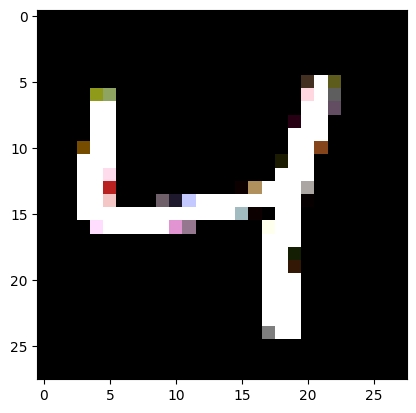

In [ ]:
import time
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier

# Definir y cargar el modelo
# Aquí debes definir tu modelo y clasificador. Por ejemplo:
# model = YourModel()
# classifier = PyTorchClassifier(model=model, ...)

# Definir las transformaciones de preprocesamiento
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir imágenes a tensores de PyTorch
    transforms.Normalize((0.1307,), (0.3081,))  # Normalizar con la media y desviación estándar de MNIST
])

# Descargar el conjunto de datos MNIST
mnist_dataset = MNIST(root='./data', train=True, download=True, transform=transform)

# Crear un DataLoader para cargar las primeras 50 imágenes
data_loader = DataLoader(mnist_dataset, batch_size=3, shuffle=False)

# Obtener el primer lote de imágenes
images, labels = next(iter(data_loader))

# Convertir el lote de imágenes a numpy y cambiar el tipo de dato a float32
input_batch = images.numpy().astype(np.float32)

# Duplicar el canal para convertir de 1 canal a 3 canales
input_batch = np.repeat(input_batch, 3, axis=1)

# Mostrar la primera imagen del lote para verificar
input_image = input_batch[0].transpose((1, 2, 0))
plt.imshow(input_image.squeeze(), cmap='gray')  # Usar 'squeeze' para eliminar la dimensión extra
plt.show()

print(f"Shape of input_batch: {input_batch.shape}")
print(f"Length of input_batch: {len(input_batch)}")

# Definir el ataque Projected Gradient Descent
pgd_attack = ProjectedGradientDescent(classifier, max_iter=60, eps_step=0.01, eps=0.3)

# Aplicar el ataque a las primeras 50 imágenes
start = time.time()
x_test_adv = pgd_attack.generate(x=input_batch)
print("Time for attack (in seconds): {}".format(time.time() - start))

# Mostrar la primera imagen adversarial del lote para verificar
adv_image = x_test_adv[2].transpose((1, 2, 0))
plt.imshow(adv_image.squeeze(), cmap='gray')
plt.show()




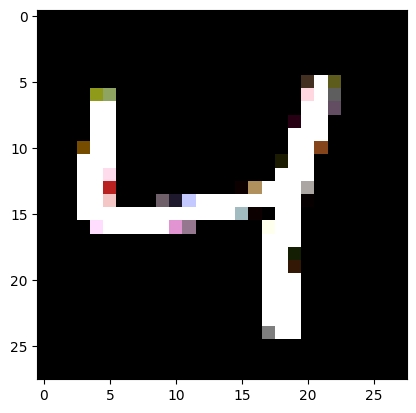

In [ ]:
adv_image = x_test_adv[2].transpose((1, 2, 0))
plt.imshow(adv_image.squeeze(), cmap='gray')
plt.show()


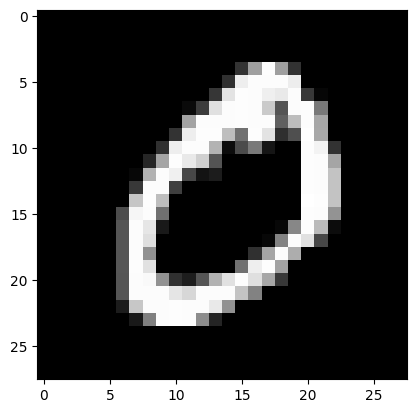

Shape of input_batch: (50, 1, 28, 28)
Length of input_batch: 50


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Definir las transformaciones de preprocesamiento
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir imágenes a tensores de PyTorch
    transforms.Normalize((0.1307,), (0.3081,))  # Normalizar con la media y desviación estándar de MNIST
])

# Descargar el conjunto de datos MNIST
mnist_dataset = MNIST(root='./data', train=True, download=True, transform=transform)

# Crear un DataLoader para cargar las primeras 50 imágenes
data_loader = DataLoader(mnist_dataset, batch_size=50, shuffle=False)

# Obtener el primer lote de imágenes
images, labels = next(iter(data_loader))

# Convertir el lote de imágenes a numpy y cambiar el tipo de dato a float32
input_batch = images.numpy().astype(np.float32)

# Mostrar la primera imagen del lote para verificar
input_image = input_batch[1].transpose((1, 2, 0))
plt.imshow(input_image.squeeze(), cmap='gray')  # Usar 'squeeze' para eliminar la dimensión extra
plt.show()

print(f"Shape of input_batch: {input_batch.shape}")
print(f"Length of input_batch: {len(input_batch)}")


1


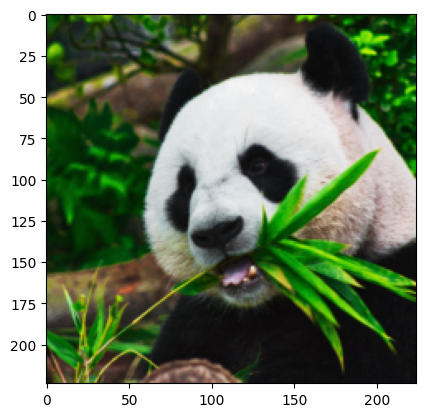

In [ ]:
import requests
url = "https://raw.githubusercontent.com/fukashi-hatake/kaggle_notebooks/main/images/giant_panda.jpg"
input_image = Image.open(requests.get(url, stream=True).raw)

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0).numpy().astype(np.float32)
print(len(input_batch))
input = input_batch[0].transpose((1,2,0))
plt.imshow(input)

In [ ]:
preds = classifier.predict(input_batch)
print(np.argmax(preds, axis=1))

accuracy = np.max(softmax_activation(preds), axis=1)
accuracy = round(accuracy[0], 2)
print("Accuracy on benign examples: {}%".format(accuracy * 100))

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[50, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [ ]:
pgd_attack = ProjectedGradientDescent(classifier, max_iter=60, eps_step=0.01, eps=0.3)

start = time.time()
x_test_adv = pgd_attack.generate(x=input_batch)
print("Time for attack (in seconds): {}".format(time.time()-start))

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[32, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [ ]:
predictions = classifier.predict(x_test_adv)
print(np.argmax(predictions, axis=1))

accuracy = round(np.max(softmax_activation(predictions), axis=1)[0]*100,2)
print("Accuracy on adversarial test examples: {}%".format(accuracy))

[317]
Accuracy on adversarial test examples: 100.0%


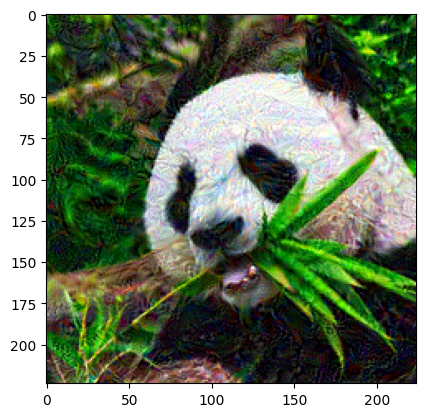

In [ ]:
input = x_test_adv[0].transpose((1,2,0))
plt.imshow(input)

In [ ]:
noise = compare_images(input_batch[0].transpose(1,2,0), x_test_adv[0].transpose(1,2,0))
print("Amount of noise: {}".format(noise))

Amount of noise: 0.39289623498916626


In [ ]:
!pip install adversarial-robustness-toolbox


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.5 MB/s eta 0:00:00


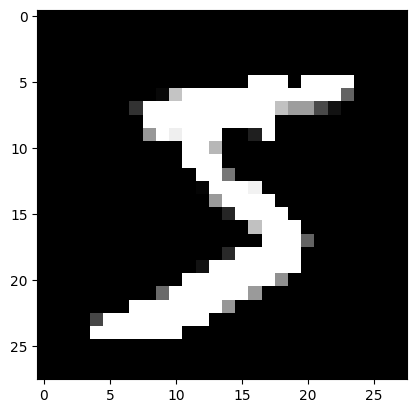

Shape of input_batch: (300, 3, 28, 28)
Length of input_batch: 300


PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Time for attack (in seconds): 280.88027453422546


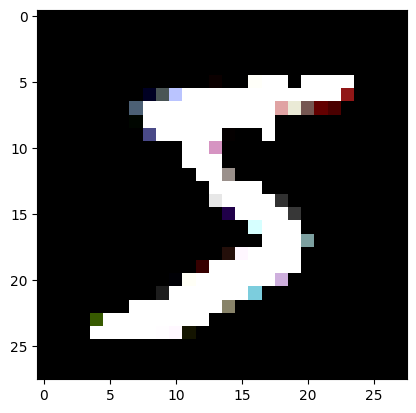

Number of misclassified adversarial examples: 300
Total number of adversarial examples: 300
Accuracy on adversarial test examples: 100.00%


In [ ]:
import time
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
from scipy.special import softmax

# Definir y cargar el modelo
# Aquí debes definir tu modelo y clasificador. Por ejemplo:
# model = YourModel()
# classifier = PyTorchClassifier(model=model, ...)

# Definir las transformaciones de preprocesamiento
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir imágenes a tensores de PyTorch
    transforms.Normalize((0.1307,), (0.3081,))  # Normalizar con la media y desviación estándar de MNIST
])

# Descargar el conjunto de datos MNIST
mnist_dataset = MNIST(root='./data', train=True, download=True, transform=transform)

# Crear un DataLoader para cargar las primeras 50 imágenes
data_loader = DataLoader(mnist_dataset, batch_size=300, shuffle=False)

# Obtener el primer lote de imágenes
images, labels = next(iter(data_loader))

# Convertir el lote de imágenes a numpy y cambiar el tipo de dato a float32
input_batch = images.numpy().astype(np.float32)

# Duplicar el canal para convertir de 1 canal a 3 canales
input_batch = np.repeat(input_batch, 3, axis=1)

# Mostrar la primera imagen del lote para verificar
input_image = input_batch[0].transpose((1, 2, 0))
plt.imshow(input_image.squeeze(), cmap='gray')  # Usar 'squeeze' para eliminar la dimensión extra
plt.show()

print(f"Shape of input_batch: {input_batch.shape}")
print(f"Length of input_batch: {len(input_batch)}")

# Definir el ataque Projected Gradient Descent
pgd_attack = ProjectedGradientDescent(classifier, max_iter=60, eps_step=0.01, eps=0.3)

# Aplicar el ataque a las primeras 50 imágenes
start = time.time()
x_test_adv = pgd_attack.generate(x=input_batch)
print("Time for attack (in seconds): {}".format(time.time() - start))

# Mostrar la primera imagen adversarial del lote para verificar
adv_image = x_test_adv[0].transpose((1, 2, 0))
plt.imshow(adv_image.squeeze(), cmap='gray')
plt.show()

# Obtener predicciones del clasificador para las imágenes adversarias
predictions = classifier.predict(x_test_adv)

# Obtener las etiquetas predichas (la clase con la mayor probabilidad)
predicted_labels = np.argmax(predictions, axis=1)

# Calcular el número de errores de clasificación
num_errors = np.sum(predicted_labels != labels.numpy())

# Calcular la precisión como el porcentaje de imágenes clasificadas incorrectamente
accuracy = num_errors / len(labels) * 100

print("Number of misclassified adversarial examples: {}".format(num_errors))
print("Total number of adversarial examples: {}".format(len(labels)))
print("Accuracy on adversarial test examples: {:.2f}%".format(accuracy))

Files already downloaded and verified


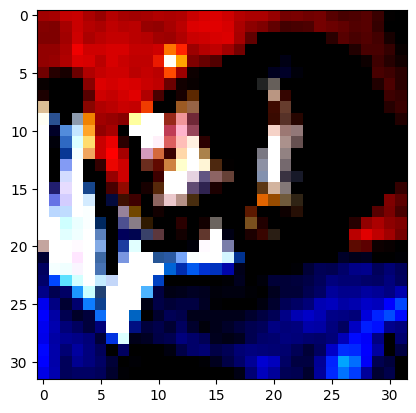

Shape of input_batch: (50, 3, 32, 32)
Length of input_batch: 50


PGD - Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Time for attack (in seconds): 52.065295457839966


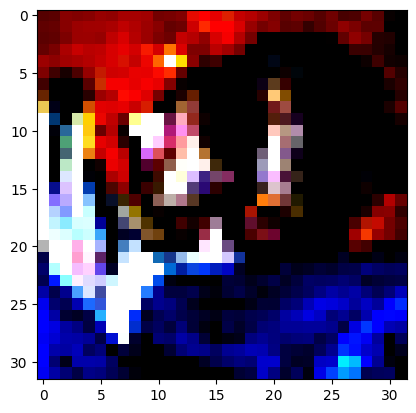

Number of misclassified adversarial examples: 44
Total number of adversarial examples: 50
Accuracy on adversarial test examples: 88.00%


In [ ]:
import time
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
import torchvision.models as models

# Definir y cargar el modelo preentrenado
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 10)  # CIFAR-10 tiene 10 clases
model.eval()

# Definir el clasificador ART
classifier = PyTorchClassifier(
    model=model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.01),
    input_shape=(3, 32, 32),
    nb_classes=10
)

# Definir las transformaciones de preprocesamiento
transform = transforms.Compose([
    transforms.Resize(32),  # Redimensionar la imagen a 32x32 píxeles
    transforms.ToTensor(),  # Convertir la imagen a un tensor de PyTorch
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])  # Normalizar con la media y desviación estándar de CIFAR-10
])

# Descargar el conjunto de datos CIFAR-10
cifar10_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Crear un DataLoader para cargar las primeras 50 imágenes
data_loader = DataLoader(cifar10_dataset, batch_size=50, shuffle=False)

# Obtener el primer lote de imágenes
images, labels = next(iter(data_loader))

# Convertir el lote de imágenes a numpy y cambiar el tipo de dato a float32
input_batch = images.numpy().astype(np.float32)

# Mostrar la primera imagen del lote para verificar
input_image = input_batch[0].transpose((1, 2, 0))
plt.imshow(input_image)
plt.show()

print(f"Shape of input_batch: {input_batch.shape}")
print(f"Length of input_batch: {len(input_batch)}")

# Definir el ataque Projected Gradient Descent
pgd_attack = ProjectedGradientDescent(classifier, max_iter=40, eps_step=0.01, eps=0.3)

# Aplicar el ataque a las primeras 50 imágenes
start = time.time()
x_test_adv = pgd_attack.generate(x=input_batch)
print("Time for attack (in seconds): {}".format(time.time() - start))

# Mostrar la primera imagen adversarial del lote para verificar
adv_image = x_test_adv[0].transpose((1, 2, 0))
plt.imshow(adv_image)
plt.show()

# Obtener predicciones del clasificador para las imágenes adversarias
predictions = classifier.predict(x_test_adv)

# Obtener las etiquetas predichas (la clase con la mayor probabilidad)
predicted_labels = np.argmax(predictions, axis=1)

# Calcular el número de errores de clasificación
num_errors = np.sum(predicted_labels != labels.numpy())

# Calcular la precisión como el porcentaje de imágenes clasificadas incorrectamente
accuracy = num_errors / len(labels) * 100

print("Number of misclassified adversarial examples: {}".format(num_errors))
print("Total number of adversarial examples: {}".format(len(labels)))
print("Accuracy on adversarial test examples: {:.2f}%".format(accuracy))



In [ ]:
import time
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
import torchvision.models as models

# Establecer la semilla para reproducibilidad
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Definir y cargar el modelo preentrenado
model = models.densenet121(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 10)  # CIFAR-10 tiene 10 clases
model.eval()

# Definir el clasificador ART
classifier = PyTorchClassifier(
    model=model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.01),
    input_shape=(3, 32, 32),
    nb_classes=10
)

# Definir las transformaciones de preprocesamiento
transform = transforms.Compose([
    transforms.Resize(32),  # Redimensionar la imagen a 32x32 píxeles
    transforms.ToTensor(),  # Convertir la imagen a un tensor de PyTorch
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])  # Normalizar con la media y desviación estándar de CIFAR-10
])

# Descargar el conjunto de datos CIFAR-10
cifar10_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Crear un DataLoader para cargar las primeras 50 imágenes
data_loader = DataLoader(cifar10_dataset, batch_size=500, shuffle=False)

# Obtener el primer lote de imágenes
images, labels = next(iter(data_loader))

# Convertir el lote de imágenes a numpy y cambiar el tipo de dato a float32
input_batch = images.numpy().astype(np.float32)

# Mostrar la primera imagen del lote para verificar
input_image = input_batch[0].transpose((1, 2, 0))
plt.imshow(input_image)
plt.show()

print(f"Shape of input_batch: {input_batch.shape}")
print(f"Length of input_batch: {len(input_batch)}")

# Definir el ataque Projected Gradient Descent
pgd_attack = ProjectedGradientDescent(classifier, max_iter=20, eps_step=0.01, eps=0.3)

# Aplicar el ataque a las primeras 50 imágenes
start = time.time()
x_test_adv = pgd_attack.generate(x=input_batch)
print("Time for attack (in seconds): {}".format(time.time() - start))

# Mostrar la primera imagen adversarial del lote para verificar
adv_image = x_test_adv[0].transpose((1, 2, 0))
plt.imshow(adv_image)
plt.show()

# Obtener predicciones del clasificador para las imágenes adversarias
predictions = classifier.predict(x_test_adv)

# Obtener las etiquetas predichas (la clase con la mayor probabilidad)
predicted_labels = np.argmax(predictions, axis=1)

# Calcular el número de errores de clasificación
num_errors = np.sum(predicted_labels != labels.numpy())

# Calcular la precisión como el porcentaje de imágenes clasificadas incorrectamente
accuracy = num_errors / len(labels) * 100

print("Number of misclassified adversarial examples: {}".format(num_errors))
print("Total number of adversarial examples: {}".format(len(labels)))
print("Accuracy on adversarial test examples: {:.2f}%".format(accuracy))


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 90.3MB/s]


AttributeError: 'DenseNet' object has no attribute 'fc'

Files already downloaded and verified


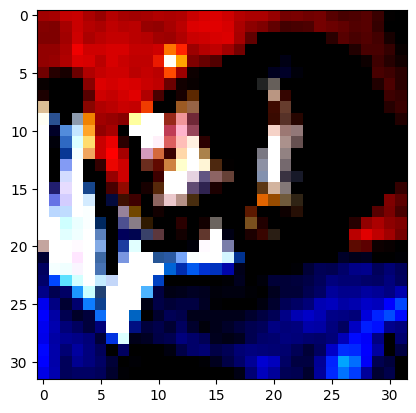

Shape of input_batch: (500, 3, 32, 32)
Length of input_batch: 500


PGD - Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Time for attack with 20 iterations (in seconds): 36.3665726184845


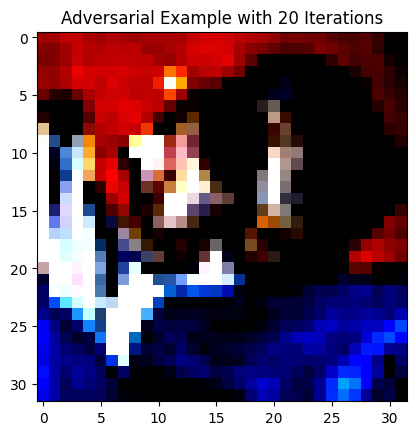

Number of misclassified adversarial examples with 20 iterations: 453
Accuracy on adversarial test examples with 20 iterations: 90.60%


In [ ]:
import time
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
import torchvision.models as models

# Establecer la semilla para reproducibilidad
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Establecer la semilla
set_seed(42)

# Definir y cargar el modelo preentrenado DenseNet121
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 10)  # CIFAR-10 tiene 10 clases
model.eval()

# Definir el clasificador ART
classifier = PyTorchClassifier(
    model=model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.01),
    input_shape=(3, 32, 32),
    nb_classes=10
)

# Definir las transformaciones de preprocesamiento
transform = transforms.Compose([
    transforms.Resize(32),  # Redimensionar la imagen a 32x32 píxeles
    transforms.ToTensor(),  # Convertir la imagen a un tensor de PyTorch
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])  # Normalizar con la media y desviación estándar de CIFAR-10
])

# Descargar el conjunto de datos CIFAR-10
cifar10_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Crear un DataLoader para cargar las primeras 50 imágenes
data_loader = DataLoader(cifar10_dataset, batch_size=500, shuffle=False)  # Se cargan 100 imágenes en cada lote

# Obtener el primer lote de imágenes
images, labels = next(iter(data_loader))

# Convertir el lote de imágenes a numpy y cambiar el tipo de dato a float32
input_batch = images.numpy().astype(np.float32)

# Mostrar la primera imagen del lote para verificar
input_image = input_batch[0].transpose((1, 2, 0))
plt.imshow(input_image)
plt.show()

print(f"Shape of input_batch: {input_batch.shape}")
print(f"Length of input_batch: {len(input_batch)}")

# Definir el ataque Projected Gradient Descent con 20 iteraciones
pgd_attack = ProjectedGradientDescent(classifier, max_iter=2, eps_step=0.01, eps=0.3)

# Aplicar el ataque a las primeras 50 imágenes
start = time.time()
x_test_adv = pgd_attack.generate(x=input_batch)
print("Time for attack with 20 iterations (in seconds): {}".format(time.time() - start))

# Mostrar la primera imagen adversarial del lote para verificar
adv_image = x_test_adv[0].transpose((1, 2, 0))
plt.imshow(adv_image)
plt.title('Adversarial Example with 20 Iterations')
plt.show()

# Obtener predicciones del clasificador para las imágenes adversarias
predictions = classifier.predict(x_test_adv)

# Obtener las etiquetas predichas (la clase con la mayor probabilidad)
predicted_labels = np.argmax(predictions, axis=1)

# Calcular el número de errores de clasificación
num_errors = np.sum(predicted_labels != labels.numpy())

# Calcular la precisión como el porcentaje de imágenes clasificadas incorrectamente
accuracy = num_errors / len(labels) * 100

print("Number of misclassified adversarial examples with 20 iterations: {}".format(num_errors))
print("Accuracy on adversarial test examples with 20 iterations: {:.2f}%".format(accuracy))


Files already downloaded and verified


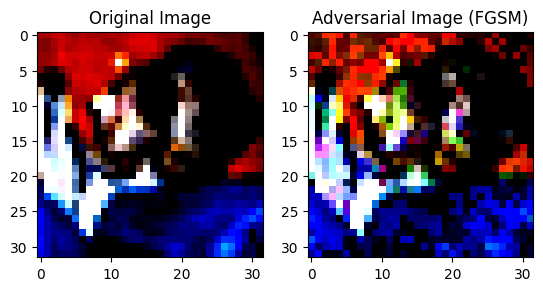

Number of misclassified adversarial examples with FGSM: 452
Accuracy on adversarial test examples with FGSM: 90.40%


In [ ]:
import time
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models

# Establecer la semilla para reproducibilidad
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Establecer la semilla
set_seed(42)

# Definir y cargar el modelo preentrenado ResNet-50
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 10)  # CIFAR-10 tiene 10 clases
model.eval()

# Definir las transformaciones de preprocesamiento
transform = transforms.Compose([
    transforms.Resize(32),  # Redimensionar la imagen a 32x32 píxeles
    transforms.ToTensor(),  # Convertir la imagen a un tensor de PyTorch
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])  # Normalizar con la media y desviación estándar de CIFAR-10
])

# Descargar el conjunto de datos CIFAR-10
cifar10_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Crear un DataLoader para cargar las primeras 100 imágenes
data_loader = DataLoader(cifar10_dataset, batch_size=500, shuffle=False)

# Obtener el primer lote de imágenes
images, labels = next(iter(data_loader))

# Convertir las imágenes a tensores y mover a dispositivo
images = images.to(torch.float32)
images.requires_grad = True
labels = labels.to(torch.long)

# Hacer una predicción inicial
outputs = model(images)
loss = F.cross_entropy(outputs, labels)

# Calcular los gradientes de la pérdida con respecto a las imágenes de entrada
model.zero_grad()
loss.backward()

# Obtener el signo del gradiente
grad_sign = images.grad.sign()

# Definir el parámetro epsilon
epsilon = 0.3

# Generar las imágenes adversariales
adv_images = images + epsilon * grad_sign
adv_images = torch.clamp(adv_images, 0, 1)  # Asegurar que los valores de los píxeles estén en el rango [0, 1]

# Mostrar la primera imagen original y adversarial
original_image = images[0].detach().cpu().numpy().transpose((1, 2, 0))
adv_image = adv_images[0].detach().cpu().numpy().transpose((1, 2, 0))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image)

plt.subplot(1, 2, 2)
plt.title('Adversarial Image (FGSM)')
plt.imshow(adv_image)

plt.show()

# Obtener predicciones del clasificador para las imágenes adversarias
outputs_adv = model(adv_images)
predicted_labels_adv = torch.argmax(outputs_adv, dim=1)

# Calcular el número de errores de clasificación
num_errors = (predicted_labels_adv != labels).sum().item()

# Calcular la precisión como el porcentaje de imágenes clasificadas incorrectamente
accuracy = num_errors / len(labels) * 100

print("Number of misclassified adversarial examples with FGSM: {}".format(num_errors))
print("Accuracy on adversarial test examples with FGSM: {:.2f}%".format(accuracy))


Files already downloaded and verified


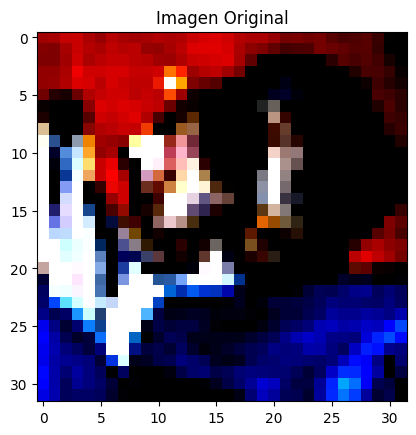

Shape of input_batch: (50, 3, 32, 32)
Length of input_batch: 50


PGD - Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Time for attack with 20 iterations (in seconds): 29.89478063583374


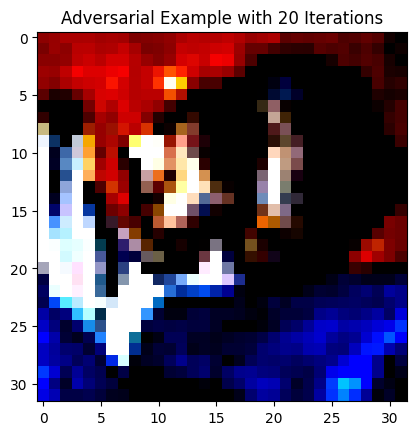

Number of misclassified adversarial examples with 20 iterations: 49
Accuracy on adversarial test examples with 20 iterations: 98.00%


In [ ]:
import time
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
import torchvision.models as models

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 10)  # CIFAR-10 tiene 10 clases
model.eval()

classifier = PyTorchClassifier(
    model=model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.01),
    input_shape=(3, 32, 32),
    nb_classes=10
)

transform = transforms.Compose([
    transforms.Resize(32),  # Redimensionar la imagen a 32x32 píxeles
    transforms.ToTensor(),  # Convertir la imagen a un tensor de PyTorch
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])  # Normalizar con la media y desviación estándar de CIFAR-10
])

cifar10_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

data_loader = DataLoader(cifar10_dataset, batch_size=50, shuffle=False)  # Se cargan 50 imágenes en cada lote

images, labels = next(iter(data_loader))

input_batch = images.numpy().astype(np.float32)

# Mostrar la primera imagen del lote para verificar
input_image = input_batch[0].transpose((1, 2, 0))
plt.imshow(input_image)
plt.title('Imagen Original')
plt.show()

print(f"Shape of input_batch: {input_batch.shape}")
print(f"Length of input_batch: {len(input_batch)}")

# Definir el ataque Projected Gradient Descent con 20 iteraciones
pgd_attack = ProjectedGradientDescent(classifier, max_iter=20, eps_step=0.01, eps=0.3)

# Aplicar el ataque a las primeras 50 imágenes
start = time.time()
x_test_adv = pgd_attack.generate(x=input_batch)
print("Time for attack with 20 iterations (in seconds): {}".format(time.time() - start))

# Mostrar la primera imagen adversarial del lote para verificar
adv_image = x_test_adv[0].transpose((1, 2, 0))
plt.imshow(adv_image)
plt.title('Adversarial Example with 20 Iterations')
plt.show()

# Obtener predicciones del clasificador para las imágenes adversarias
predictions = classifier.predict(x_test_adv)

# Obtener las etiquetas predichas (la clase con la mayor probabilidad)
predicted_labels = np.argmax(predictions, axis=1)

# Calcular el número de errores de clasificación
num_errors = np.sum(predicted_labels != labels.numpy())

# Calcular la precisión como el porcentaje de imágenes clasificadas incorrectamente
accuracy = num_errors / len(labels) * 100

print("Number of misclassified adversarial examples with 20 iterations: {}".format(num_errors))
print("Accuracy on adversarial test examples with 20 iterations: {:.2f}%".format(accuracy))


170498071/170498071 [==============================] - 2s 0us/step


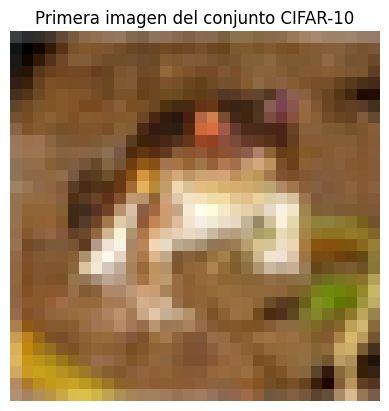

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

(train_images, _), (_, _) = cifar10.load_data()

plt.imshow(train_images[0])
plt.title('Primera imagen del conjunto CIFAR-10')
plt.axis('off')
plt.show()


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

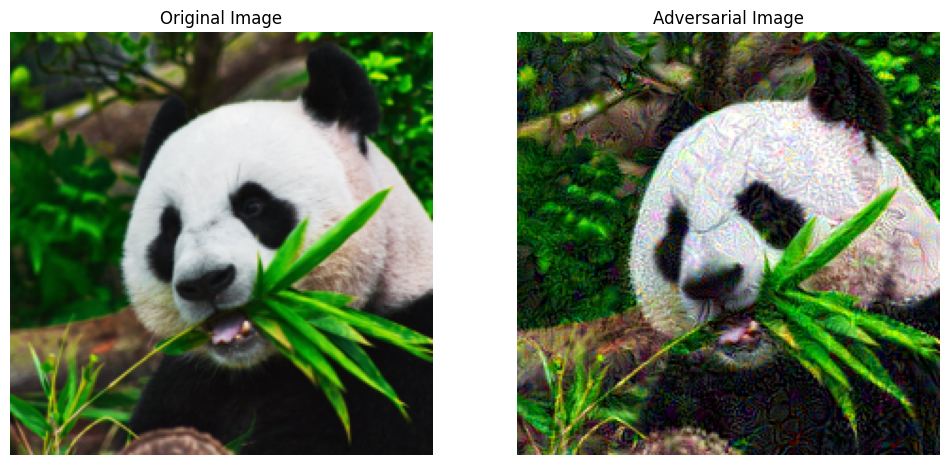

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import ProjectedGradientDescent

def load_image(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
    return image, image_tensor

image_url = "https://raw.githubusercontent.com/fukashi-hatake/kaggle_notebooks/main/images/giant_panda.jpg"
image, image_tensor = load_image(image_url)

model = models.resnet50(pretrained=True)
model.eval()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 224, 224),
    nb_classes=1000,
)

pgd_attack = ProjectedGradientDescent(classifier, max_iter=60, eps_step=0.01, eps=0.3)

image_tensor.requires_grad = True
adversarial_image_tensor = pgd_attack.generate(x=image_tensor.detach().numpy())

def tensor_to_image(tensor):
    tensor = tensor.squeeze(0)
    tensor = torch.clamp(tensor, 0, 1)
    return transforms.ToPILImage()(tensor)

original_image = transforms.ToPILImage()(image_tensor.squeeze(0))
adversarial_image = tensor_to_image(torch.tensor(adversarial_image_tensor))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Adversarial Image")
plt.imshow(adversarial_image)
plt.axis('off')

plt.show()

